In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
from itertools import chain
from matplotlib import pyplot as plt

date = "2023-03-29"

In [2]:
def get_all_metrics (payload):
    global count
    print(count)
    FAIR_checker_api = "https://fair-checker.france-bioinformatique.fr/api/check/metrics_all"
    try:
        response = requests.get(FAIR_checker_api, params=payload)
        print(payload)
        print(response.status_code)
        print("________________")
        count += 1
        return response.json(), response.status_code
    except requests.JSONDecodeError:
        status = 504
        print(payload)
        print(status)
        print("________________")
        return None, status

In [3]:
def get_metrics_from_result(assessment_result):
    return [item.get('metric') for item in assessment_result]

def get_scores_from_result(assessment_result):
    return [int(item.get('score')) for item in assessment_result]

In [4]:
def get_principle_from_metric(metric):
    if metric.startswith('F'):
        return 'findable'
    elif metric.startswith('A'):
        return 'accessible'
    elif metric.startswith('I'):
        return 'interoperable'
    else:
        return 'reusable'

Metric descriptions as stated on the FAIR-Checker website: https://fair-checker.france-bioinformatique.fr/check
- Findable
    - F1A: Unique IDs - FAIRChecker check that the resource identifier is an URL that can be reach, meaning it is unique, it is even better if the URL refer to a DOI. 
    - F1B: Persistent IDs - Weak : FAIR-Checker verifies that at least one namespace from identifiers.org is used in metadata. Strong : FAIR-Checker verifies that the “identifier” property from DCTerms or Schema.org vocabularies is present in metadata. 
    - F2A: Structured metadata - FAIR-Checker verifies that at least one RDF triple can be found in metadata. 
    - F2B: Shared vocabularies for metadata - Weak: FAIR-Checker verifies that at least one used ontology class or property are known in major ontology registries (OLS, BioPortal, LOV); Strong: FAIR-Checker verifies that all used ontology classes or properties are known in major ontology registries (OLS, BioPortal, LOV)
- Accessible
    - A1.1: Open resolution protocol - FAIR-Checker verifies that the resource is accessible via an open protocol, for instance the protocol needs to be HTTP. 
- Interoperable
    - I1: Machine readable format - FAIR-Checker verifies that at least one RDF triple can be found in metadata.
    - I2: Use shared ontologies - Weak: FAIR-Checker verifies that at least one used ontology class or property are known in major ontology registries (OLS, BioPortal, LOV); Strong: FAIR-Checker verifies that all used ontology classes or properties are known in major ontology registries (OLS, BioPortal, LOV)
    - I3: External links - FAIR-Checker verifies that at least 3 different URL authorities are used in the URIs of RDF metadata.
- Reusable
    - R1.1: Metadata includes license - FAIR-Checker verifies that at least one license property from Schema.org, DCTerms, or DOAP ontologies are found in metadata. 
    - R1.2: Metadata includes provenance - FAIR-Checker verifies that at least one provenance property from PROV, DCTerms, or PAV ontologies are found in metadata. 
    - R1.3: Community standards - Weak: FAIR-Checker verifies that at least one used ontology class or property are known in major ontology registries (OLS, BioPortal, LOV); Strong: FAIR-Checker verifies that all used ontology classes or properties are known in major ontology registries (OLS, BioPortal, LOV) 

# Papers

## Papers via DOI

### Paper assessment via DOI

In [5]:
%%script false --no-raise-error
orkg_doi_df = pd.read_pickle("orkg_papers_"+date+".pkl")
orkg_doi_df

Couldn't find program: 'false'


In [6]:
%%script false --no-raise-error
# FAIR-Checker assessment for all ORKG papers with a valid doi
# Executing this approximately takes 1,505 minutes
# If you don't have the time, use the latest .pkl file :)
count = 0
assessment_results = orkg_doi_df['doi'].map(lambda x: get_all_metrics(payload={'url': 'https://doi.org/' + x}))
orkg_doi_df['FAIR_assessment'] = [aresult[0] for aresult in assessment_results]
orkg_doi_df['assessment_status_code'] = [aresult[1] for aresult in assessment_results]
orkg_doi_df.to_pickle("./orkg_doi_df_FAIRChecker_assessment"+date+".pkl")
orkg_doi_df

Couldn't find program: 'false'


### Paper evaluation via DOI + visualisations

In [7]:
# using the .pkl from the doi paper assessments
# only keeping successful assessments
orkg_doi_df = pd.read_pickle("orkg_doi_df_FAIRChecker_assessment2023-03-29.pkl")
print(orkg_doi_df["assessment_status_code"].value_counts())
orkg_doi_df = orkg_doi_df[orkg_doi_df["assessment_status_code"] == 200]
orkg_doi_df = orkg_doi_df.drop(labels=["assessment_status_code"], axis=1)
orkg_doi_df.reset_index(drop=True)

200    4770
504     150
500      29
Name: assessment_status_code, dtype: int64


,paper,doi,research_field_label,FAIR_assessment
0,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
1,http://orkg.org/orkg/resource/R107618,10.1007/s11423-020-09885-z,Learner-Interface Interaction,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
2,http://orkg.org/orkg/resource/R107663,10.1111/1467-8535.00213,Learner-Interface Interaction,"[{'metric': 'F1A', 'score': '0', 'target_uri':..."
3,http://orkg.org/orkg/resource/R107834,10.32870/Ap.v12n2.1910,Learner-Interface Interaction,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
4,http://orkg.org/orkg/resource/R107843,10.19173/irrodl.v4i2.149,Learner-Interface Interaction,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
...,...,...,...,...
4765,http://orkg.org/orkg/resource/R8441,10.1016/j.jbiotec.2013.12.009,Systems Biology,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
4766,http://orkg.org/orkg/resource/R9154,10.1073/pnas.1913007117,Life Sciences,"[{'metric': 'F1A', 'score': '0', 'target_uri':..."
4767,http://orkg.org/orkg/resource/R9190,10.1007/978-3-319-54064-1_3,Biotechnology,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
4768,http://orkg.org/orkg/resource/R9295,10.1038/nprot.2016.182,Biotechnology,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."


In [8]:
assessment_df = pd.DataFrame()

papers = list(chain.from_iterable([[x]*11 for x in orkg_doi_df['paper']]))
assessment_df['paper'] = papers

research_fields = list(chain.from_iterable([[x]*11 for x in orkg_doi_df['research_field_label']]))
assessment_df['research_field'] = research_fields

dois = list(chain.from_iterable([[x]*11 for x in orkg_doi_df['doi']]))
assessment_df['doi'] = dois

metrics = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in orkg_doi_df['FAIR_assessment']]))
assessment_df['metric'] = metrics

scores = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in orkg_doi_df['FAIR_assessment']]))
assessment_df['score'] = scores

assessment_df

,paper,research_field,doi,metric,score
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,10.1186/s12866-016-0676-9,F1A,2
1,http://orkg.org/orkg/resource/R1004,Bioinformatics,10.1186/s12866-016-0676-9,F1B,0
2,http://orkg.org/orkg/resource/R1004,Bioinformatics,10.1186/s12866-016-0676-9,F2A,2
3,http://orkg.org/orkg/resource/R1004,Bioinformatics,10.1186/s12866-016-0676-9,F2B,2
4,http://orkg.org/orkg/resource/R1004,Bioinformatics,10.1186/s12866-016-0676-9,A1.1,2
...,...,...,...,...,...
52465,http://orkg.org/orkg/resource/R9639,Computer Sciences,10.1007/978-3-030-30760-8_18,I2,2
52466,http://orkg.org/orkg/resource/R9639,Computer Sciences,10.1007/978-3-030-30760-8_18,I3,0
52467,http://orkg.org/orkg/resource/R9639,Computer Sciences,10.1007/978-3-030-30760-8_18,R1.1,0
52468,http://orkg.org/orkg/resource/R9639,Computer Sciences,10.1007/978-3-030-30760-8_18,R1.2,0


In [9]:
aggregate_funcs = {'research_field': 'first', 'doi': 'first', 'score': 'sum'}
total_score_df = assessment_df.groupby('paper', as_index=False).agg(aggregate_funcs)
total_score_df

,paper,research_field,doi,score
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,10.1186/s12866-016-0676-9,18
1,http://orkg.org/orkg/resource/R107618,Learner-Interface Interaction,10.1007/s11423-020-09885-z,16
2,http://orkg.org/orkg/resource/R107663,Learner-Interface Interaction,10.1111/1467-8535.00213,2
3,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,10.32870/Ap.v12n2.1910,4
4,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,10.19173/irrodl.v4i2.149,4
...,...,...,...,...
4765,http://orkg.org/orkg/resource/R8441,Systems Biology,10.1016/j.jbiotec.2013.12.009,4
4766,http://orkg.org/orkg/resource/R9154,Life Sciences,10.1073/pnas.1913007117,2
4767,http://orkg.org/orkg/resource/R9190,Biotechnology,10.1007/978-3-319-54064-1_3,14
4768,http://orkg.org/orkg/resource/R9295,Biotechnology,10.1038/nprot.2016.182,16


In [10]:
print(total_score_df["score"].mean())
print(total_score_df["score"].median())
# possible max = 22
print(total_score_df["score"].max())
print(total_score_df[total_score_df["score"]==20])
# possible min = 0
print(total_score_df["score"].min())

6.351991614255765
4.0
20
                                     paper research_field  \
341  http://orkg.org/orkg/resource/R159706        Science   

                      doi  score  
341  10.5281/ZENODO.59011     20  
2


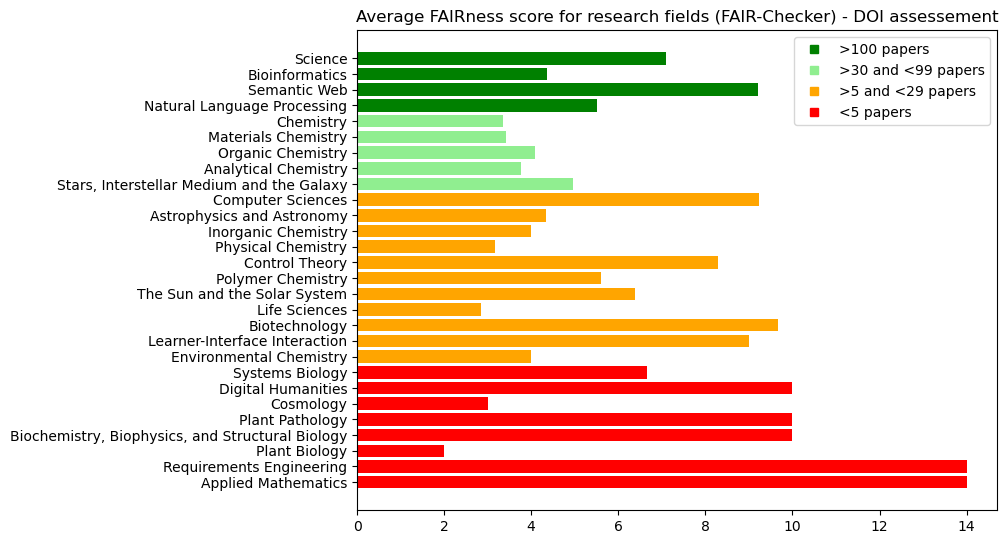

In [11]:
eval1_df = total_score_df.groupby("research_field").agg({"score": "sum"})
eval1_df["counts"] = total_score_df["research_field"].value_counts()
eval1_df = eval1_df.sort_values("counts")
eval1_df["avg_score"] = eval1_df["score"] / eval1_df["counts"]
eval1_df = eval1_df.drop(labels=["score"], axis=1)
eval1_df = eval1_df.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = eval1_df['research_field']
avg_scores = eval1_df['avg_score']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in eval1_df["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (FAIR-Checker) - DOI assessement")
plt.show()

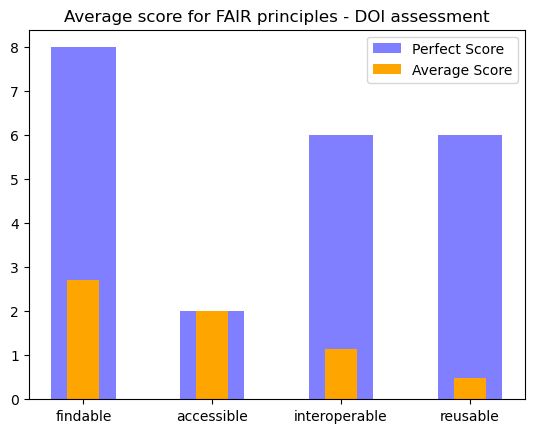

In [12]:
# max scores: F = 8, A = 2, I = 6, R = 6
principle_assessment_df = assessment_df
principle_assessment_df['principle'] = [get_principle_from_metric(x) for x in principle_assessment_df['metric']]

aggregate_funcs = {'score': 'sum', 'principle': 'first'}
principle_assessment_df = principle_assessment_df.groupby(['principle'], as_index=False).agg(aggregate_funcs)
principle_assessment_df['avg_metric_score'] = principle_assessment_df['score']/len(orkg_doi_df)

principle_assessment_df['principle'] = pd.Categorical(principle_assessment_df['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
principle_assessment_df = principle_assessment_df.sort_values('principle')

#plotting
width = 0.5
perfect_scores = [8, 2, 6, 6]
actual_scores = principle_assessment_df['avg_metric_score']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, principle_assessment_df['principle'] )
plt.title("Average score for FAIR principles - DOI assessment")
plt.legend()
plt.show()

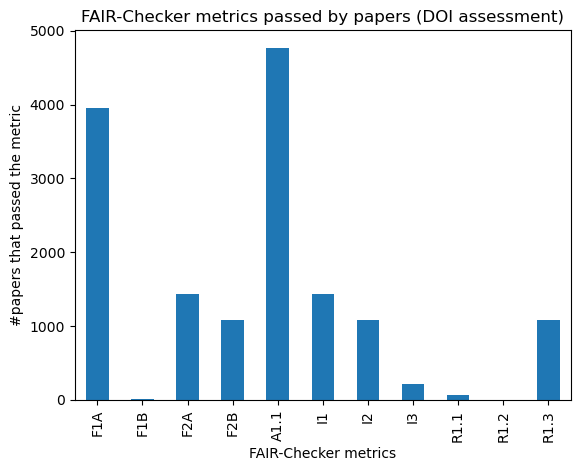

In [67]:
metric_assessment_doi_df = assessment_df
aggregate_funcs = {"score": "sum"}
metric_assessment_doi_df = metric_assessment_doi_df.groupby("metric").agg(aggregate_funcs).reset_index()
metric_assessment_doi_df["score"] = metric_assessment_doi_df["score"] / 2

metric_assessment_doi_df['metric'] = pd.Categorical(metric_assessment_doi_df['metric'], ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
metric_assessment_doi_df = metric_assessment_doi_df.sort_values('metric')

metric_assessment_doi_df["score"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
plt.title("FAIR-Checker metrics passed by papers (DOI assessment)")
plt.ylabel("#papers that passed the metric")
plt.xlabel("FAIR-Checker metrics")
plt.show()

## Papers via ORKG resource URL

### Paper assessment via ORKG resource URL

In [13]:
%%script false --no-raise-error
orkg_url_df = pd.read_csv("paper_query_result_2023-03-29.csv", encoding="ISO-8859-1")
orkg_url_df = orkg_url_df[["paper", "paper_title", "url", "research_field_label"]]
orkg_url_df = orkg_url_df.groupby("paper").agg({"paper_title": "first", "url": "first", "research_field_label": "first"}).reset_index()
orkg_url_df = orkg_url_df.drop(labels=["url"], axis=1)
orkg_url_df

Couldn't find program: 'false'


In [14]:
%%script false --no-raise-error
# FAIR-Checker assessment for all ORKG papers with an ORKG resource URL
# Executing this approximately takes 1,716 minutes
# If you don't have the time, use the latest .pkl file :)
count = 0
assessment_results = orkg_url_df['paper'].map(lambda x: get_all_metrics(payload={'url': x}))
orkg_url_df['FAIR_assessment'] = [aresult[0] for aresult in assessment_results]
orkg_url_df['assessment_status_code'] = [aresult[1] for aresult in assessment_results]
orkg_url_df.to_pickle("./orkg_url_df_FAIRChecker_assessment"+date+".pkl")
orkg_url_df

Couldn't find program: 'false'


### Paper evaluation via ORKG resource URL + visualizations

In [15]:
orkg_url_df = pd.read_pickle("orkg_url_df_FAIRChecker_assessment2023-03-29.pkl")
print(orkg_url_df["assessment_status_code"].value_counts())
orkg_url_df = orkg_url_df[orkg_url_df["assessment_status_code"] == 200].reset_index(drop=True)
orkg_url_df

200    9856
500    2786
504     355
Name: assessment_status_code, dtype: int64


,paper,paper_title,research_field_label,FAIR_assessment,assessment_status_code
0,http://orkg.org/orkg/resource/R1004,"A semi-automated, KNIME-based workflow for bio...",Bioinformatics,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
1,http://orkg.org/orkg/resource/R107663,Dimensions of transactional distance in the wo...,Learner-Interface Interaction,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
2,http://orkg.org/orkg/resource/R107834,The future of learner-interface interaction. A...,Learner-Interface Interaction,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
3,http://orkg.org/orkg/resource/R107843,Getting the Mix Right Again: An updated and th...,Learner-Interface Interaction,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
4,http://orkg.org/orkg/resource/R108460,Outsourcing Proofs of Retrievability,Science,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
...,...,...,...,...,...
9851,http://orkg.org/orkg/resource/R78345,Recognition Properties of Cucurbit[7]uril Self...,Physical Chemistry,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
9852,http://orkg.org/orkg/resource/R8376,Solving Sorting of Rolling Stock Problems Util...,Applied Mathematics,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
9853,http://orkg.org/orkg/resource/R8426,The Cassini Enceladus encounters 2005â2010 i...,The Sun and the Solar System,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
9854,http://orkg.org/orkg/resource/R8441,Investigating the feasibility of scale up and ...,Systems Biology,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200


In [16]:
assessment_orkgurl_df = pd.DataFrame()

papers = list(chain.from_iterable([[x]*11 for x in orkg_url_df['paper']]))
assessment_orkgurl_df['paper'] = papers

research_fields = list(chain.from_iterable([[x]*11 for x in orkg_url_df['research_field_label']]))
assessment_orkgurl_df['research_field'] = research_fields

metrics = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in orkg_url_df['FAIR_assessment']]))
assessment_orkgurl_df['metric'] = metrics

scores = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in orkg_url_df['FAIR_assessment']]))
assessment_orkgurl_df['score'] = scores

assessment_orkgurl_df

,paper,research_field,metric,score
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,F1A,2
1,http://orkg.org/orkg/resource/R1004,Bioinformatics,F1B,0
2,http://orkg.org/orkg/resource/R1004,Bioinformatics,F2A,2
3,http://orkg.org/orkg/resource/R1004,Bioinformatics,F2B,2
4,http://orkg.org/orkg/resource/R1004,Bioinformatics,A1.1,2
...,...,...,...,...
108411,http://orkg.org/orkg/resource/R9154,Life Sciences,I2,2
108412,http://orkg.org/orkg/resource/R9154,Life Sciences,I3,2
108413,http://orkg.org/orkg/resource/R9154,Life Sciences,R1.1,0
108414,http://orkg.org/orkg/resource/R9154,Life Sciences,R1.2,0


In [17]:
aggregate_funcs = {'research_field': 'first', 'score': 'sum'}
total_score_orkgurl_df = assessment_orkgurl_df.groupby('paper', as_index=False).agg(aggregate_funcs)
total_score_orkgurl_df

,paper,research_field,score
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,16
1,http://orkg.org/orkg/resource/R107663,Learner-Interface Interaction,14
2,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,16
3,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,14
4,http://orkg.org/orkg/resource/R108460,Science,14
...,...,...,...
9851,http://orkg.org/orkg/resource/R78345,Physical Chemistry,14
9852,http://orkg.org/orkg/resource/R8376,Applied Mathematics,14
9853,http://orkg.org/orkg/resource/R8426,The Sun and the Solar System,14
9854,http://orkg.org/orkg/resource/R8441,Systems Biology,16


In [18]:
print(total_score_orkgurl_df["score"].mean())
print(total_score_orkgurl_df["score"].median())
# possible max = 16
print(total_score_orkgurl_df["score"].max())
# possible min = 2
print(total_score_orkgurl_df["score"].min())

13.825689935064934
14.0
16
2


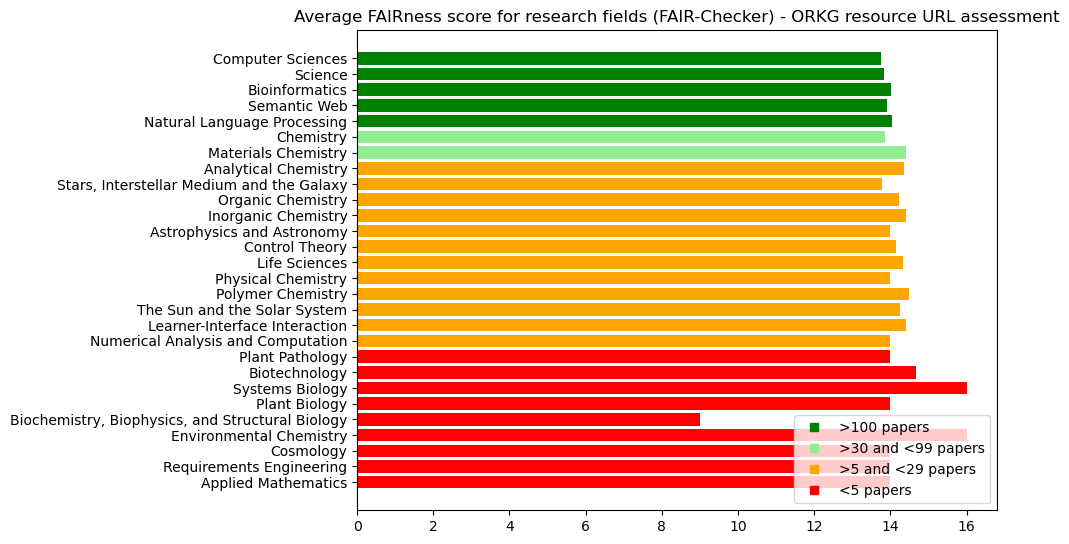

In [19]:
eval2_df = total_score_orkgurl_df.groupby("research_field").agg({"score": "sum"})
eval2_df["counts"] = total_score_orkgurl_df["research_field"].value_counts()
eval2_df = eval2_df.sort_values("counts")
eval2_df["avg_score"] = eval2_df["score"] / eval2_df["counts"]
eval2_df = eval2_df.drop(labels=["score"], axis=1)
eval2_df = eval2_df.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = eval2_df['research_field']
avg_scores = eval2_df['avg_score']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in eval2_df["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (FAIR-Checker) - ORKG resource URL assessment")
plt.show()

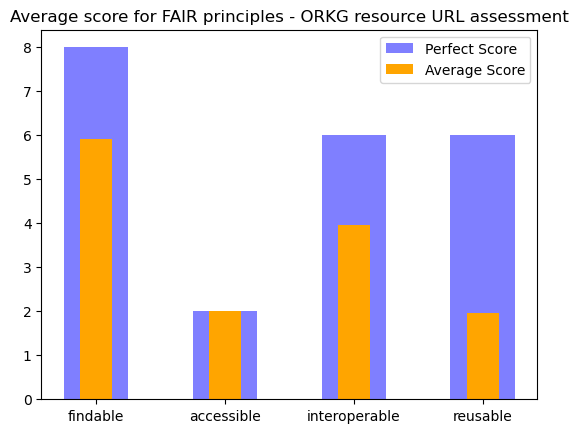

In [20]:
# max scores: F = 8, A = 2, I = 6, R = 6
principle_assessment_orkgurl_df = assessment_orkgurl_df
principle_assessment_orkgurl_df['principle'] = [get_principle_from_metric(x) for x in principle_assessment_orkgurl_df['metric']]

aggregate_funcs = {'score': 'sum', 'principle': 'first'}
principle_assessment_orkgurl_df = principle_assessment_orkgurl_df.groupby(['principle'], as_index=False).agg(aggregate_funcs)
principle_assessment_orkgurl_df['avg_metric_score'] = principle_assessment_orkgurl_df['score']/len(orkg_url_df)

principle_assessment_orkgurl_df['principle'] = pd.Categorical(principle_assessment_orkgurl_df['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
principle_assessment_orkgurl_df = principle_assessment_orkgurl_df.sort_values('principle')

#plotting
width = 0.5
perfect_scores = [8, 2, 6, 6]
actual_scores = principle_assessment_orkgurl_df['avg_metric_score']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, principle_assessment_orkgurl_df['principle'] )
plt.title("Average score for FAIR principles - ORKG resource URL assessment")
plt.legend()
plt.show()

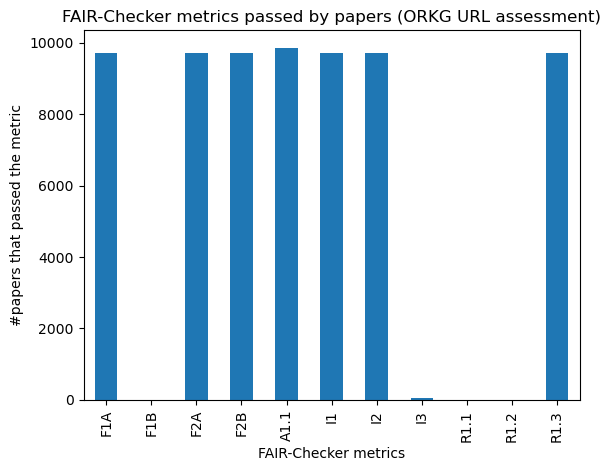

In [68]:
metric_assessment_orkgurl_df = assessment_orkgurl_df
aggregate_funcs = {"score": "sum"}
metric_assessment_orkgurl_df = metric_assessment_orkgurl_df.groupby("metric").agg(aggregate_funcs).reset_index()
metric_assessment_orkgurl_df["score"] = metric_assessment_orkgurl_df["score"] / 2

metric_assessment_orkgurl_df['metric'] = pd.Categorical(metric_assessment_orkgurl_df['metric'], ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
metric_assessment_orkgurl_df = metric_assessment_orkgurl_df.sort_values('metric')

metric_assessment_orkgurl_df["score"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
plt.title("FAIR-Checker metrics passed by papers (ORKG URL assessment)")
plt.ylabel("#papers that passed the metric")
plt.xlabel("FAIR-Checker metrics")
plt.show()

## Papers via standard URL

### Paper assessment via standard URL

In [21]:
%%script false --no-raise-error
orkg_stdurl_df = pd.read_csv("paper_query_result_2023-03-29.csv", encoding="ISO-8859-1")
orkg_stdurl_df = orkg_stdurl_df[["paper", "paper_title", "url", "research_field_label"]]
orkg_stdurl_df = orkg_stdurl_df.groupby("paper").agg({"paper_title": "first", "url": "first", "research_field_label": "first"})
orkg_stdurl_df = orkg_stdurl_df[orkg_stdurl_df["url"].isna() == False].reset_index()
orkg_stdurl_df

Couldn't find program: 'false'


In [22]:
%%script false --no-raise-error
# FAIR-Checker assessment for all ORKG papers with a standard URL
# Executing this approximately takes 2,471 minutes
# If you don't have the time, use the latest .pkl file :)
count = 0
assessment_results = orkg_stdurl_df['url'].map(lambda x: get_all_metrics(payload={'url': x}))
orkg_stdurl_df['FAIR_assessment'] = [aresult[0] for aresult in assessment_results]
orkg_stdurl_df['assessment_status_code'] = [aresult[1] for aresult in assessment_results]
orkg_stdurl_df.to_pickle("./orkg_stdurl_df_FAIRChecker_assessment"+date+".pkl")
orkg_stdurl_df

Couldn't find program: 'false'


### Paper evaluation via standard URL + visualizations

In [23]:
orkg_stdurl_df = pd.read_pickle("orkg_stdurl_df_FAIRChecker_assessment2023-03-29.pkl")
print(orkg_stdurl_df["assessment_status_code"].value_counts())
orkg_stdurl_df = orkg_stdurl_df[orkg_stdurl_df["assessment_status_code"] == 200].reset_index(drop=True)
orkg_stdurl_df

200    7580
500     486
504       3
Name: assessment_status_code, dtype: int64


,paper,paper_title,url,research_field_label,FAIR_assessment,assessment_status_code
0,http://orkg.org/orkg/resource/R107843,Getting the Mix Right Again: An updated and th...,http://www.irrodl.org/index.php/irrodl/article...,Learner-Interface Interaction,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
1,http://orkg.org/orkg/resource/R108529,DistrustRank: Spotting False News Domains,https://dl.acm.org/doi/10.1145/3201064.3201083,Computer Sciences,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
2,http://orkg.org/orkg/resource/R108693,Genetically modified organisms and food securi...,https://doi.org/10.1080/21645698.2020.1794489,Biotechnology,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
3,http://orkg.org/orkg/resource/R108704,Anastomosis Groups and Pathogenicity of Rhizoc...,https://apsjournals.apsnet.org/doi/10.1094/PDI...,Plant Pathology,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
4,http://orkg.org/orkg/resource/R108713,Anastomosis groups and pathogenicity of binucl...,https://link.springer.com/article/10.1007/s106...,Plant Pathology,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
...,...,...,...,...,...,...
7575,http://orkg.org/orkg/resource/R78136,Hypertension prevalence in human coronavirus d...,https://www.sciencedirect.com/science/article/...,Life Sciences,"[{'metric': 'F1A', 'score': '0', 'target_uri':...",200
7576,http://orkg.org/orkg/resource/R78139,Effect of temperature on the infectivity of CO...,https://www.sciencedirect.com/science/article/...,Life Sciences,"[{'metric': 'F1A', 'score': '0', 'target_uri':...",200
7577,http://orkg.org/orkg/resource/R78145,Modeling Palestinian COVID-19 Cumulative Confi...,https://www.sciencedirect.com/science/article/...,Life Sciences,"[{'metric': 'F1A', 'score': '0', 'target_uri':...",200
7578,http://orkg.org/orkg/resource/R78301,Petroleum Hydrocarbons Contamination of Surfac...,http://www.sciepub.com/JEPHH/abstract/8843,Environmental Chemistry,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200


In [24]:
assessment_stdurl_df = pd.DataFrame()

papers = list(chain.from_iterable([[x]*11 for x in orkg_stdurl_df['paper']]))
assessment_stdurl_df['paper'] = papers

research_fields = list(chain.from_iterable([[x]*11 for x in orkg_stdurl_df['research_field_label']]))
assessment_stdurl_df['research_field'] = research_fields

urls = list(chain.from_iterable([[x]*11 for x in orkg_stdurl_df['url']]))
assessment_stdurl_df['url'] = urls

metrics = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in orkg_stdurl_df['FAIR_assessment']]))
assessment_stdurl_df['metric'] = metrics

scores = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in orkg_stdurl_df['FAIR_assessment']]))
assessment_stdurl_df['score'] = scores

assessment_stdurl_df

,paper,research_field,url,metric,score
0,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,http://www.irrodl.org/index.php/irrodl/article...,F1A,2
1,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,http://www.irrodl.org/index.php/irrodl/article...,F1B,0
2,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,http://www.irrodl.org/index.php/irrodl/article...,F2A,0
3,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,http://www.irrodl.org/index.php/irrodl/article...,F2B,0
4,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,http://www.irrodl.org/index.php/irrodl/article...,A1.1,2
...,...,...,...,...,...
83375,http://orkg.org/orkg/resource/R78345,Physical Chemistry,https://pubs.acs.org/doi/abs/10.1021/la202346r,I2,0
83376,http://orkg.org/orkg/resource/R78345,Physical Chemistry,https://pubs.acs.org/doi/abs/10.1021/la202346r,I3,0
83377,http://orkg.org/orkg/resource/R78345,Physical Chemistry,https://pubs.acs.org/doi/abs/10.1021/la202346r,R1.1,0
83378,http://orkg.org/orkg/resource/R78345,Physical Chemistry,https://pubs.acs.org/doi/abs/10.1021/la202346r,R1.2,0


In [25]:
aggregate_funcs = {'research_field': 'first', 'url': 'first', 'score': 'sum'}
total_score_stdurl_df = assessment_stdurl_df.groupby('paper', as_index=False).agg(aggregate_funcs)
total_score_stdurl_df

,paper,research_field,url,score
0,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,http://www.irrodl.org/index.php/irrodl/article...,4
1,http://orkg.org/orkg/resource/R108529,Computer Sciences,https://dl.acm.org/doi/10.1145/3201064.3201083,4
2,http://orkg.org/orkg/resource/R108693,Biotechnology,https://doi.org/10.1080/21645698.2020.1794489,14
3,http://orkg.org/orkg/resource/R108704,Plant Pathology,https://apsjournals.apsnet.org/doi/10.1094/PDI...,4
4,http://orkg.org/orkg/resource/R108713,Plant Pathology,https://link.springer.com/article/10.1007/s106...,16
...,...,...,...,...
7575,http://orkg.org/orkg/resource/R78136,Life Sciences,https://www.sciencedirect.com/science/article/...,2
7576,http://orkg.org/orkg/resource/R78139,Life Sciences,https://www.sciencedirect.com/science/article/...,2
7577,http://orkg.org/orkg/resource/R78145,Life Sciences,https://www.sciencedirect.com/science/article/...,2
7578,http://orkg.org/orkg/resource/R78301,Environmental Chemistry,http://www.sciepub.com/JEPHH/abstract/8843,4


In [26]:
print(total_score_stdurl_df["score"].mean())
print(total_score_stdurl_df["score"].median())
# possible max = 16
print(total_score_stdurl_df["score"].max())
# possible min = 2
print(total_score_stdurl_df["score"].min())

3.7600263852242746
4.0
18
2


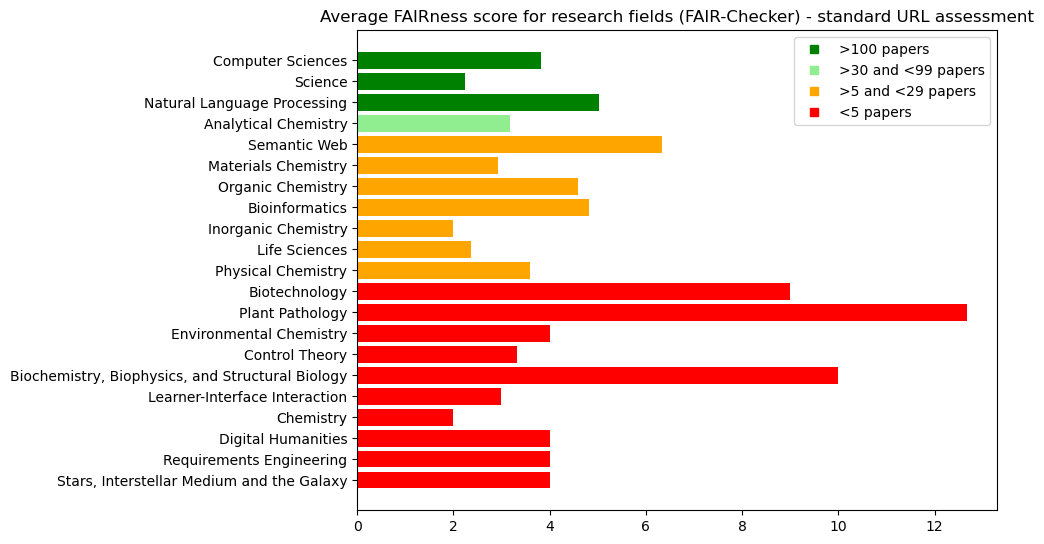

In [27]:
eval3_df = total_score_stdurl_df.groupby("research_field").agg({"score": "sum"})
eval3_df["counts"] = total_score_stdurl_df["research_field"].value_counts()
eval3_df = eval3_df.sort_values("counts")
eval3_df["avg_score"] = eval3_df["score"] / eval3_df["counts"]
eval3_df = eval3_df.drop(labels=["score"], axis=1)
eval3_df = eval3_df.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = eval3_df['research_field']
avg_scores = eval3_df['avg_score']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in eval3_df["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (FAIR-Checker) - standard URL assessment")
plt.show()

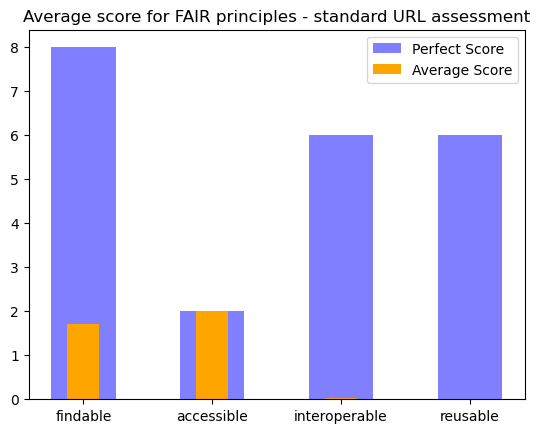

In [28]:
# max scores: F = 8, A = 2, I = 6, R = 6
principle_assessment_stdurl_df = assessment_stdurl_df
principle_assessment_stdurl_df['principle'] = [get_principle_from_metric(x) for x in principle_assessment_stdurl_df['metric']]

aggregate_funcs = {'score': 'sum', 'principle': 'first'}
principle_assessment_stdurl_df = principle_assessment_stdurl_df.groupby(['principle'], as_index=False).agg(aggregate_funcs)
principle_assessment_stdurl_df['avg_metric_score'] = principle_assessment_stdurl_df['score']/len(orkg_stdurl_df)

principle_assessment_stdurl_df['principle'] = pd.Categorical(principle_assessment_stdurl_df['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
principle_assessment_stdurl_df = principle_assessment_stdurl_df.sort_values('principle')

#plotting
width = 0.5
perfect_scores = [8, 2, 6, 6]
actual_scores = principle_assessment_stdurl_df['avg_metric_score']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, principle_assessment_stdurl_df['principle'] )
plt.title("Average score for FAIR principles - standard URL assessment")
plt.legend()
plt.show()

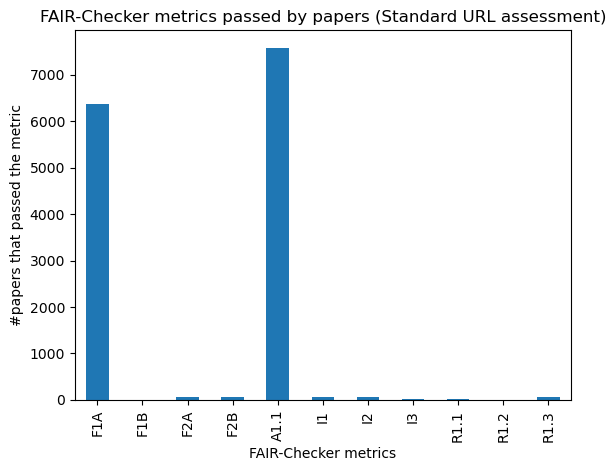

In [69]:
metric_assessment_stdurl_df = assessment_stdurl_df
aggregate_funcs = {"score": "sum"}
metric_assessment_stdurl_df = metric_assessment_stdurl_df.groupby("metric").agg(aggregate_funcs).reset_index()
metric_assessment_stdurl_df["score"] = metric_assessment_stdurl_df["score"] / 2

metric_assessment_stdurl_df['metric'] = pd.Categorical(metric_assessment_stdurl_df['metric'], ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
metric_assessment_stdurl_df = metric_assessment_stdurl_df.sort_values('metric')

metric_assessment_stdurl_df["score"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
plt.title("FAIR-Checker metrics passed by papers (Standard URL assessment)")
plt.ylabel("#papers that passed the metric")
plt.xlabel("FAIR-Checker metrics")
plt.show()

## Comparison of Papers: DOI vs. ORKG resource URL vs. standard URL

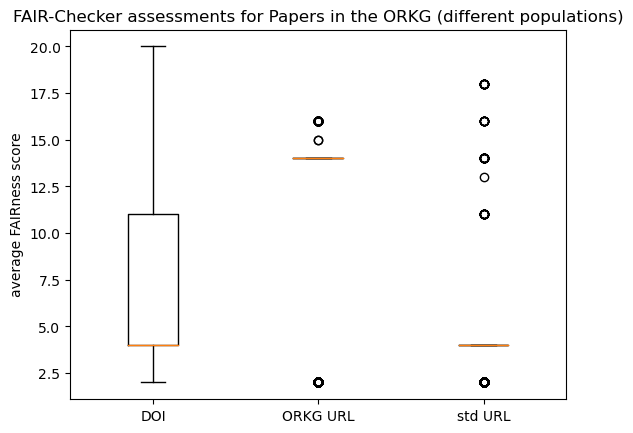

In [29]:
doi_df = total_score_df
orkg_resource_url_df = total_score_orkgurl_df
std_url_df = total_score_stdurl_df

assessement_data = [doi_df["score"], orkg_resource_url_df["score"], std_url_df["score"]]
plt.boxplot(assessement_data)
plt.title("FAIR-Checker assessments for Papers in the ORKG (different populations)")
locs, labels = plt.xticks()
plt.xticks(locs, ["DOI", "ORKG URL", "std URL"])
plt.ylabel("average FAIRness score")
plt.show()

In [30]:
doi_orkg_df = pd.merge(doi_df, orkg_resource_url_df, on=["paper", "research_field"], suffixes=("_doi", "_orkg"))
doi_orkg_stdurl_df = pd.merge(doi_orkg_df, std_url_df, on=["paper", "research_field"])
doi_orkg_stdurl_df = doi_orkg_stdurl_df.rename(columns={"score": "score_url"})
doi_orkg_stdurl_df = doi_orkg_stdurl_df[["paper", "research_field", "doi", "url", "score_doi", "score_orkg", "score_url"]]
doi_orkg_stdurl_df

,paper,research_field,doi,url,score_doi,score_orkg,score_url
0,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,10.19173/irrodl.v4i2.149,http://www.irrodl.org/index.php/irrodl/article...,4,14,4
1,http://orkg.org/orkg/resource/R108529,Computer Sciences,10.1145/3201064.3201083,https://dl.acm.org/doi/10.1145/3201064.3201083,4,14,4
2,http://orkg.org/orkg/resource/R108704,Plant Pathology,10.1094/pdis-02-15-0236-re,https://apsjournals.apsnet.org/doi/10.1094/PDI...,4,14,4
3,http://orkg.org/orkg/resource/R108713,Plant Pathology,10.1007/s10658-014-0409-6,https://link.springer.com/article/10.1007/s106...,16,14,16
4,http://orkg.org/orkg/resource/R108865,Bioinformatics,10.1186/s12859-019-3284-5,https://doi.org/10.1186/s12859-019-3284-5,18,16,18
...,...,...,...,...,...,...,...
436,http://orkg.org/orkg/resource/R285303,Computer Sciences,10.1371/journal.pbio.1001745,https://arxiv.org/abs/1210.0530,4,14,4
437,http://orkg.org/orkg/resource/R288372,Requirements Engineering,10.1007/978-3-030-03673-7_11,https://arxiv.org/abs/1809.00804,14,14,4
438,http://orkg.org/orkg/resource/R369982,Science,10.1615/Int.J.UncertaintyQuantification.201300...,https://www.dl.begellhouse.com/journals/52034e...,14,14,14
439,http://orkg.org/orkg/resource/R74963,"Biochemistry, Biophysics, and Structural Biology",10.1186/1471-2105-10-168,http://www.biomedcentral.com/1471-2105/10/168,18,2,18


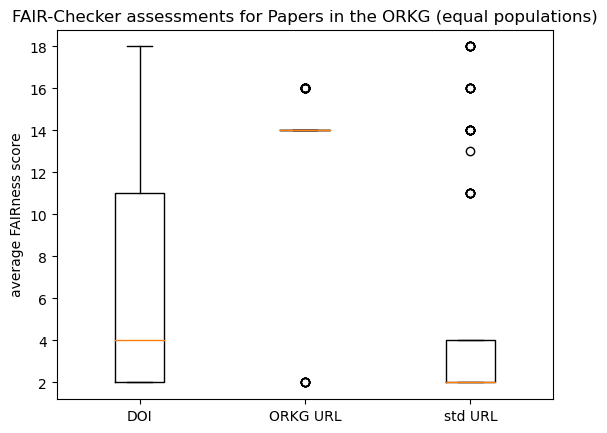

In [31]:
assessement_data_merged = [doi_orkg_stdurl_df["score_doi"], doi_orkg_stdurl_df["score_orkg"], doi_orkg_stdurl_df["score_url"]]
plt.boxplot(assessement_data_merged)
plt.title("FAIR-Checker assessments for Papers in the ORKG (equal populations)")
locs, labels = plt.xticks()
plt.xticks(locs, ["DOI", "ORKG URL", "std URL"])
plt.ylabel("average FAIRness score")
plt.show()

# Comparisons

## Comparisons evaluation via DOI

### Comparison assessment via DOI

In [32]:
%%script false --no-raise-error
comparison_df = pd.read_csv("comparison_query_result_2023-03-29.csv")
comparison_doi_df = comparison_df[comparison_df["doi"].isna() == False].reset_index(drop=True)
comparison_doi_df

Couldn't find program: 'false'


In [33]:
%%script false --no-raise-error
# FAIR-Checker assessment for all ORKG comparisons with a valid doi
# Executing this approximately takes 25 minutes
# If you don't have the time, use the latest .pkl file :)
count = 0
assessment_results = comparison_doi_df['doi'].map(lambda x: get_all_metrics(payload={'url': 'https://doi.org/' + x}))
comparison_doi_df['FAIR_assessment'] = [aresult[0] for aresult in assessment_results]
comparison_doi_df['assessment_status_code'] = [aresult[1] for aresult in assessment_results]
comparison_doi_df.to_pickle("./comparison_doi_df_FAIRChecker_assessment"+date+".pkl")
comparison_doi_df

Couldn't find program: 'false'


### Comparison evaluation via DOI + visualizations

In [34]:
comparison_doi_df = pd.read_pickle("comparison_doi_df_FAIRChecker_assessment2023-03-29.pkl")
print(comparison_doi_df["assessment_status_code"].value_counts())
comparison_doi_df = comparison_doi_df[comparison_doi_df["assessment_status_code"] == 200]
comparison_doi_df = comparison_doi_df.drop(labels=["assessment_status_code"], axis=1)
comparison_doi_df

200    294
Name: assessment_status_code, dtype: int64


,comparisons,doi,FAIR_assessment
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
1,http://orkg.org/orkg/resource/R140449,10.48366/r140449,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
2,http://orkg.org/orkg/resource/R140463,10.48366/r140463,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
3,http://orkg.org/orkg/resource/R140465,10.48366/r140465,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
4,http://orkg.org/orkg/resource/R140714,10.48366/r140714,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
...,...,...,...
289,http://orkg.org/orkg/resource/R576872,10.48366/r576872,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
290,http://orkg.org/orkg/resource/R576873,10.48366/r576873,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
291,http://orkg.org/orkg/resource/R576874,10.48366/r576874,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."
292,http://orkg.org/orkg/resource/R576875,10.48366/r576875,"[{'metric': 'F1A', 'score': '2', 'target_uri':..."


In [35]:
assessment_compdoi_df = pd.DataFrame()

comparisons = list(chain.from_iterable([[x]*11 for x in comparison_doi_df['comparisons']]))
assessment_compdoi_df['comparison'] = comparisons

dois = list(chain.from_iterable([[x]*11 for x in comparison_doi_df['doi']]))
assessment_compdoi_df['doi'] = dois

metrics = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in comparison_doi_df['FAIR_assessment']]))
assessment_compdoi_df['metric'] = metrics

scores = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in comparison_doi_df['FAIR_assessment']]))
assessment_compdoi_df['score'] = scores

assessment_compdoi_df

,comparison,doi,metric,score
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1A,2
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1B,0
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F2A,2
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F2B,2
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,A1.1,2
...,...,...,...,...
3229,http://orkg.org/orkg/resource/R576876,10.48366/r576876,I2,2
3230,http://orkg.org/orkg/resource/R576876,10.48366/r576876,I3,0
3231,http://orkg.org/orkg/resource/R576876,10.48366/r576876,R1.1,0
3232,http://orkg.org/orkg/resource/R576876,10.48366/r576876,R1.2,0


In [36]:
aggregate_funcs = {'doi': 'first', 'score': 'sum'}
total_score_compdoi_df = assessment_compdoi_df.groupby('comparison', as_index=False).agg(aggregate_funcs)
total_score_compdoi_df

,comparison,doi,score
0,http://orkg.org/orkg/resource/R107854,10.48366/r107854,14
1,http://orkg.org/orkg/resource/R108358,10.48366/r108358,14
2,http://orkg.org/orkg/resource/R108601,10.48366/r108601,14
3,http://orkg.org/orkg/resource/R108719,10.48366/r108719,14
4,http://orkg.org/orkg/resource/R109041,10.48366/r109041,14
...,...,...,...
289,http://orkg.org/orkg/resource/R76906,10.48366/r76906,14
290,http://orkg.org/orkg/resource/R78163,10.48366/r78163,14
291,http://orkg.org/orkg/resource/R78454,10.48366/r78454,14
292,http://orkg.org/orkg/resource/R8342,10.48366/r8342,14


In [37]:
print(total_score_compdoi_df["score"].mean())
print(total_score_compdoi_df["score"].median())
# possible max = 14
print(total_score_compdoi_df["score"].max())
# possible min = 14
print(total_score_compdoi_df["score"].min())

14.0
14.0
14
14


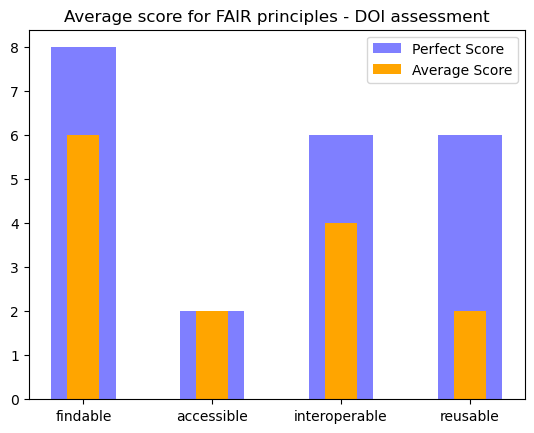

In [38]:
# max scores: F = 8, A = 2, I = 6, R = 6
principle_assessment_compdoi_df = assessment_compdoi_df
principle_assessment_compdoi_df['principle'] = [get_principle_from_metric(x) for x in principle_assessment_compdoi_df['metric']]

aggregate_funcs = {'score': 'sum', 'principle': 'first'}
principle_assessment_compdoi_df = principle_assessment_compdoi_df.groupby(['principle'], as_index=False).agg(aggregate_funcs)
principle_assessment_compdoi_df['avg_metric_score'] = principle_assessment_compdoi_df['score']/len(comparison_doi_df)

principle_assessment_compdoi_df['principle'] = pd.Categorical(principle_assessment_compdoi_df['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
principle_assessment_compdoi_df = principle_assessment_compdoi_df.sort_values('principle')

#plotting
width = 0.5
perfect_scores = [8, 2, 6, 6]
actual_scores = principle_assessment_compdoi_df['avg_metric_score']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, principle_assessment_compdoi_df['principle'] )
plt.title("Average score for FAIR principles - DOI assessment")
plt.legend()
plt.show()

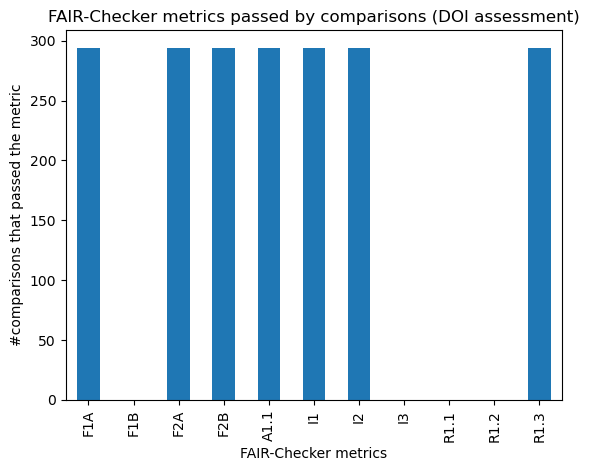

In [70]:
metric_assessment_compdoi_df = assessment_compdoi_df
aggregate_funcs = {"score": "sum"}
metric_assessment_compdoi_df = metric_assessment_compdoi_df.groupby("metric").agg(aggregate_funcs).reset_index()
metric_assessment_compdoi_df["score"] = metric_assessment_compdoi_df["score"] / 2

metric_assessment_compdoi_df['metric'] = pd.Categorical(metric_assessment_compdoi_df['metric'], ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
metric_assessment_compdoi_df = metric_assessment_compdoi_df.sort_values('metric')

metric_assessment_compdoi_df["score"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
plt.title("FAIR-Checker metrics passed by comparisons (DOI assessment)")
plt.ylabel("#comparisons that passed the metric")
plt.xlabel("FAIR-Checker metrics")
plt.show()

## Comparisons evaluation via ORKG resource URL

### Comparison assessment via ORKG resource URL

In [39]:
%%script false --no-raise-error
comparison_orkg_df = pd.read_csv("comparison_query_result_2023-03-29.csv")
comparison_orkg_df

Couldn't find program: 'false'


In [40]:
%%script false --no-raise-error
# FAIR-Checker assessment for all ORKG comparisons with an ORKG resource URL
# Executing this approximately takes 1,505 minutes
# If you don't have the time, use the latest .pkl file :)
count = 0
assessment_results = comparison_orkg_df['comparisons'].map(lambda x: get_all_metrics(payload={'url': x}))
comparison_orkg_df['FAIR_assessment'] = [aresult[0] for aresult in assessment_results]
comparison_orkg_df['assessment_status_code'] = [aresult[1] for aresult in assessment_results]
comparison_orkg_df.to_pickle("./comparison_orkg_df_FAIRChecker_assessment"+date+".pkl")
comparison_orkg_df

Couldn't find program: 'false'


### Comparison evaluation via ORKG resource URL

In [41]:
comparison_orkg_df = pd.read_pickle("comparison_orkg_df_FAIRChecker_assessment2023-03-29.pkl")
print(comparison_orkg_df["assessment_status_code"].value_counts())
comparison_orkg_df = comparison_orkg_df[comparison_orkg_df["assessment_status_code"] == 200].reset_index(drop=True)
comparison_orkg_df

200    975
500    173
504      1
Name: assessment_status_code, dtype: int64


,comparisons,doi,FAIR_assessment,assessment_status_code
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
1,http://orkg.org/orkg/resource/R140449,10.48366/r140449,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
2,http://orkg.org/orkg/resource/R140463,10.48366/r140463,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
3,http://orkg.org/orkg/resource/R140465,10.48366/r140465,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
4,http://orkg.org/orkg/resource/R140714,10.48366/r140714,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
...,...,...,...,...
970,http://orkg.org/orkg/resource/R203903,NaN,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
971,http://orkg.org/orkg/resource/R204005,NaN,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
972,http://orkg.org/orkg/resource/R288079,NaN,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200
973,http://orkg.org/orkg/resource/R288672,NaN,"[{'metric': 'F1A', 'score': '2', 'target_uri':...",200


In [42]:
assessment_comporkg_df = pd.DataFrame()

comparisons = list(chain.from_iterable([[x]*11 for x in comparison_orkg_df['comparisons']]))
assessment_comporkg_df['comparison'] = comparisons

metrics = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in comparison_orkg_df['FAIR_assessment']]))
assessment_comporkg_df['metric'] = metrics

scores = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in comparison_orkg_df['FAIR_assessment']]))
assessment_comporkg_df['score'] = scores

assessment_comporkg_df

,comparison,metric,score
0,http://orkg.org/orkg/resource/R140347,F1A,2
1,http://orkg.org/orkg/resource/R140347,F1B,0
2,http://orkg.org/orkg/resource/R140347,F2A,2
3,http://orkg.org/orkg/resource/R140347,F2B,2
4,http://orkg.org/orkg/resource/R140347,A1.1,2
...,...,...,...
10720,http://orkg.org/orkg/resource/R288673,I2,2
10721,http://orkg.org/orkg/resource/R288673,I3,0
10722,http://orkg.org/orkg/resource/R288673,R1.1,0
10723,http://orkg.org/orkg/resource/R288673,R1.2,0


In [43]:
aggregate_funcs = {'score': 'sum'}
total_score_comporkg_df = assessment_comporkg_df.groupby('comparison', as_index=False).agg(aggregate_funcs)
total_score_comporkg_df

,comparison,score
0,http://orkg.org/orkg/resource/R107676,14
1,http://orkg.org/orkg/resource/R107854,14
2,http://orkg.org/orkg/resource/R108053,14
3,http://orkg.org/orkg/resource/R108331,14
4,http://orkg.org/orkg/resource/R108332,14
...,...,...
970,http://orkg.org/orkg/resource/R8340,14
971,http://orkg.org/orkg/resource/R8341,14
972,http://orkg.org/orkg/resource/R8342,14
973,http://orkg.org/orkg/resource/R8364,14


In [44]:
print(total_score_comporkg_df["score"].mean())
print(total_score_comporkg_df["score"].median())
# possible max = 14
print(total_score_comporkg_df["score"].max())
# possible min = 14
print(total_score_comporkg_df["score"].min())

14.0
14.0
14
14


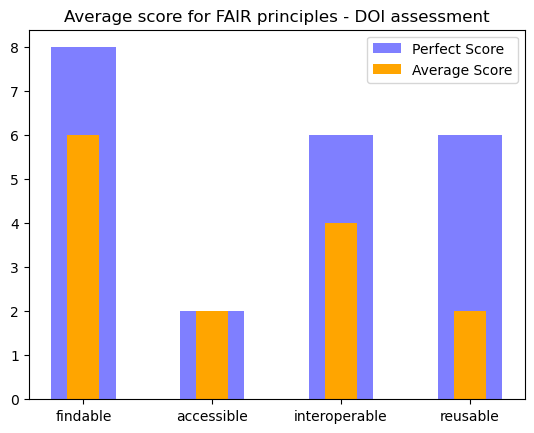

In [45]:
# max scores: F = 8, A = 2, I = 6, R = 6
principle_assessment_comporkg_df = assessment_comporkg_df
principle_assessment_comporkg_df['principle'] = [get_principle_from_metric(x) for x in principle_assessment_comporkg_df['metric']]

aggregate_funcs = {'score': 'sum', 'principle': 'first'}
principle_assessment_comporkg_df = principle_assessment_comporkg_df.groupby(['principle'], as_index=False).agg(aggregate_funcs)
principle_assessment_comporkg_df['avg_metric_score'] = principle_assessment_comporkg_df['score']/len(comparison_orkg_df)

principle_assessment_comporkg_df['principle'] = pd.Categorical(principle_assessment_comporkg_df['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
principle_assessment_comporkg_df = principle_assessment_comporkg_df.sort_values('principle')

#plotting
width = 0.5
perfect_scores = [8, 2, 6, 6]
actual_scores = principle_assessment_comporkg_df['avg_metric_score']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, principle_assessment_comporkg_df['principle'] )
plt.title("Average score for FAIR principles - DOI assessment")
plt.legend()
plt.show()

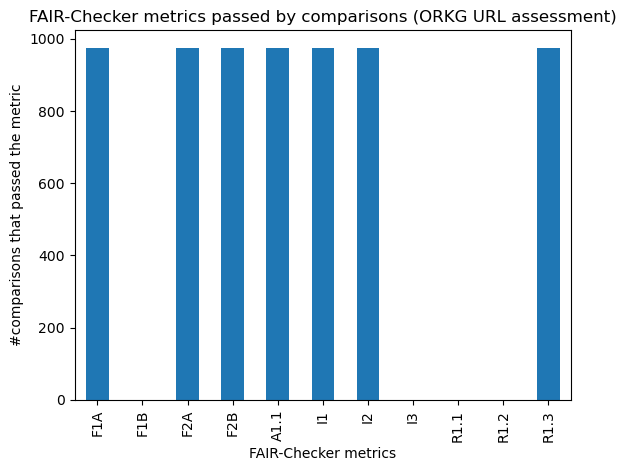

In [71]:
metric_assessment_comporkg_df = assessment_comporkg_df
aggregate_funcs = {"score": "sum"}
metric_assessment_comporkg_df = metric_assessment_comporkg_df.groupby("metric").agg(aggregate_funcs).reset_index()
metric_assessment_comporkg_df["score"] = metric_assessment_comporkg_df["score"] / 2

metric_assessment_comporkg_df['metric'] = pd.Categorical(metric_assessment_comporkg_df['metric'], ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
metric_assessment_comporkg_df = metric_assessment_comporkg_df.sort_values('metric')

metric_assessment_comporkg_df["score"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1A", "F1B", "F2A", "F2B", "A1.1", "I1", "I2", "I3", "R1.1", "R1.2", "R1.3"])
plt.title("FAIR-Checker metrics passed by comparisons (ORKG URL assessment)")
plt.ylabel("#comparisons that passed the metric")
plt.xlabel("FAIR-Checker metrics")
plt.show()

## Comparison of Comparisons: DOI vs. ORKG resource URL

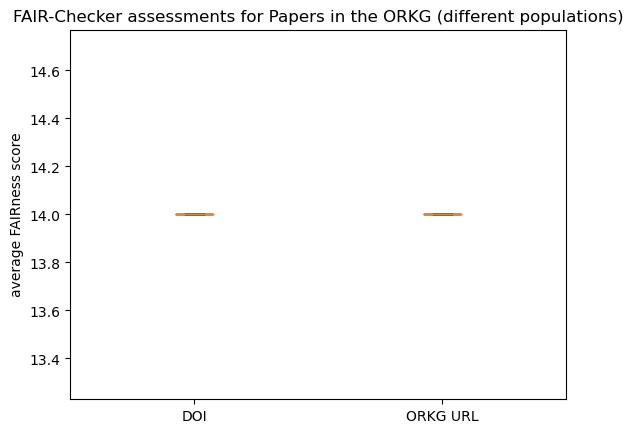

In [46]:
compdoi_df = total_score_compdoi_df
comporkg_df = total_score_comporkg_df

assessement_data = [compdoi_df["score"], comporkg_df["score"]]
plt.boxplot(assessement_data)
plt.title("FAIR-Checker assessments for Papers in the ORKG (different populations)")
locs, labels = plt.xticks()
plt.xticks(locs, ["DOI", "ORKG URL"])
plt.ylabel("average FAIRness score")
plt.show()

# Resources